In [1]:
import os
import glob
import numpy as np
import pandas as pd
import copy
import mne
from fooof import FOOOF, FOOOFGroup
import re
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

/var/folders/x4/njblnzxd78x5n8p7nz8xd3500000gn/T/ipykernel_90395/2743966091.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


In [2]:
PATH_ANALYSIS = '/Users/ao622/Dropbox (Personal)/Lab-BML/Expan/2023-10-31-FOOOF-sensitivity-analysis'
os.chdir(PATH_ANALYSIS)

# Data Wrangling

In [24]:
#df_localization = pd.read_csv('/Volumes/Nexus/Users/zouj/sEEG_data/electrode-localizations.tsv', delimiter='\t')\
#    [['Subject', 'label', 'electrode', 'is_thalamic', 'is_cortical']]

In [25]:
# spectra_file_names = glob.glob('/Volumes/Nexus/Users/zouj/sEEG_data/spectra/*')
# ch_dict = {}
# for spectra_file in spectra_file_names:
#     subject_pattern = r'EM\d{4}'
#     subject = re.findall(subject_pattern, os.path.basename(spectra_file))[0]
#     if subject not in ch_dict:
#         spectra = mne.time_frequency.read_spectrum(spectra_file)
#         ch_dict[subject] = spectra.ch_names

In [5]:
file_basenames = [os.path.basename(file_path) 
                  for file_path in glob.glob('./fooof_outputs/fooof*/fits/*fooof_group.json')]

In [6]:
dir_list = [
            './fooof_outputs/fooof_1-12_30-250hz_r0_bw1_pw25/fits',
            './fooof_outputs/fooof_5-250hz_r0_bw1_pw25/fits',
            './fooof_outputs/fooof_30-250hz_r0_bw1_pw25/fits',
            './fooof_outputs/fooof_1-150hz_r0_bw1_pw25/fits',
            './fooof_outputs/fooof_1-200hz_r0_bw1_pw25/fits',
            './fooof_outputs/fooof_1-250hz_r0_bw1_pw25/fits']

In [58]:
df_results_all = pd.DataFrame()
for dir in dir_list:
    CSVs = [file for file in glob.glob(dir + '/*fooof_aper.csv')]
    dir_name = os.path.basename(os.path.dirname(dir))
    for file in CSVs:
        df = pd.read_csv(file)
        df.insert(0, 'fitting_params', dir_name)
        df_results_all = pd.concat([df_results_all,df],axis=0, ignore_index=True)

In [59]:
df_results_all.insert(1, 'freq_range', [re.findall('fooof_(.*)_r0_bw1_pw25',params)[0].replace('_','--') for params in df_results_all['fitting_params']])

In [60]:
df_results_all.to_csv('./fooof_outputs/spectral_sensitivity_ap-params.csv')

In [61]:
df_results_ecog_dbs = df_results_all[df_results_all['electrode'].str.startswith(('ecog','dbs_L'))]

In [64]:
df_results_median = df_results_ecog_dbs.drop(['fitting_params', 'Unnamed: 0', 'idx', 'type','session_id'], axis=1).\
        groupby(by=['freq_range','subject', 'electrode']).\
        median(numeric_only=True).\
        reset_index()

In [65]:
df_results_median_pivot = df_results_median.pivot(index=['subject', 'electrode'], 
                        columns='freq_range')

# Fit 
no significant difference in fit

<Axes: xlabel='freq_range', ylabel='R2'>

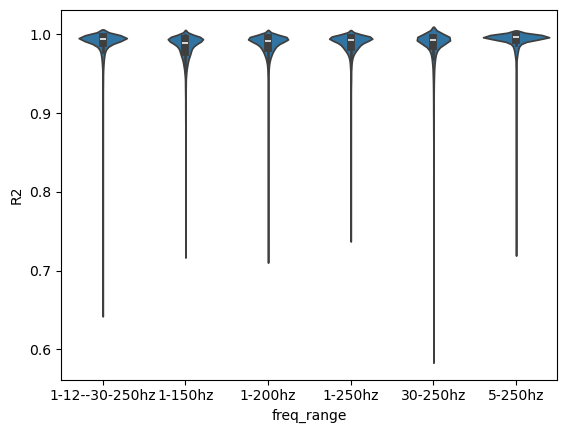

In [67]:
sns.violinplot(data=df_results_median, y="R2", x="freq_range")

<Axes: xlabel='freq_range', ylabel='error'>

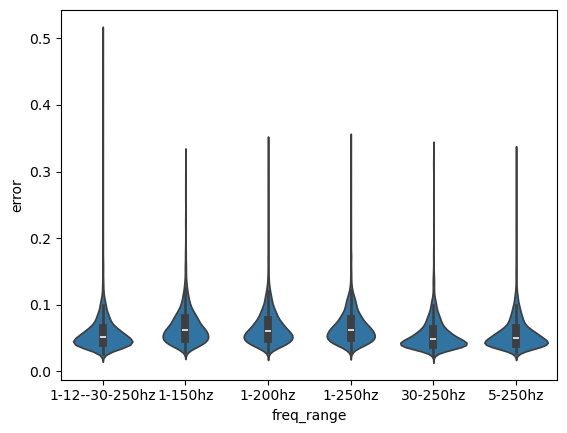

In [68]:
sns.violinplot(data=df_results_median, y="error", x="freq_range")

# Parameters 
* highly correlated
* low bias
* narrow / strong agreement intervals
    * offset < 0.3 dB
    * log knee < 0.71 --> knee ~ 3 hz with 150; knee ~ 5 hz with 250
    * exponent ~ 0.3 db/hz
    

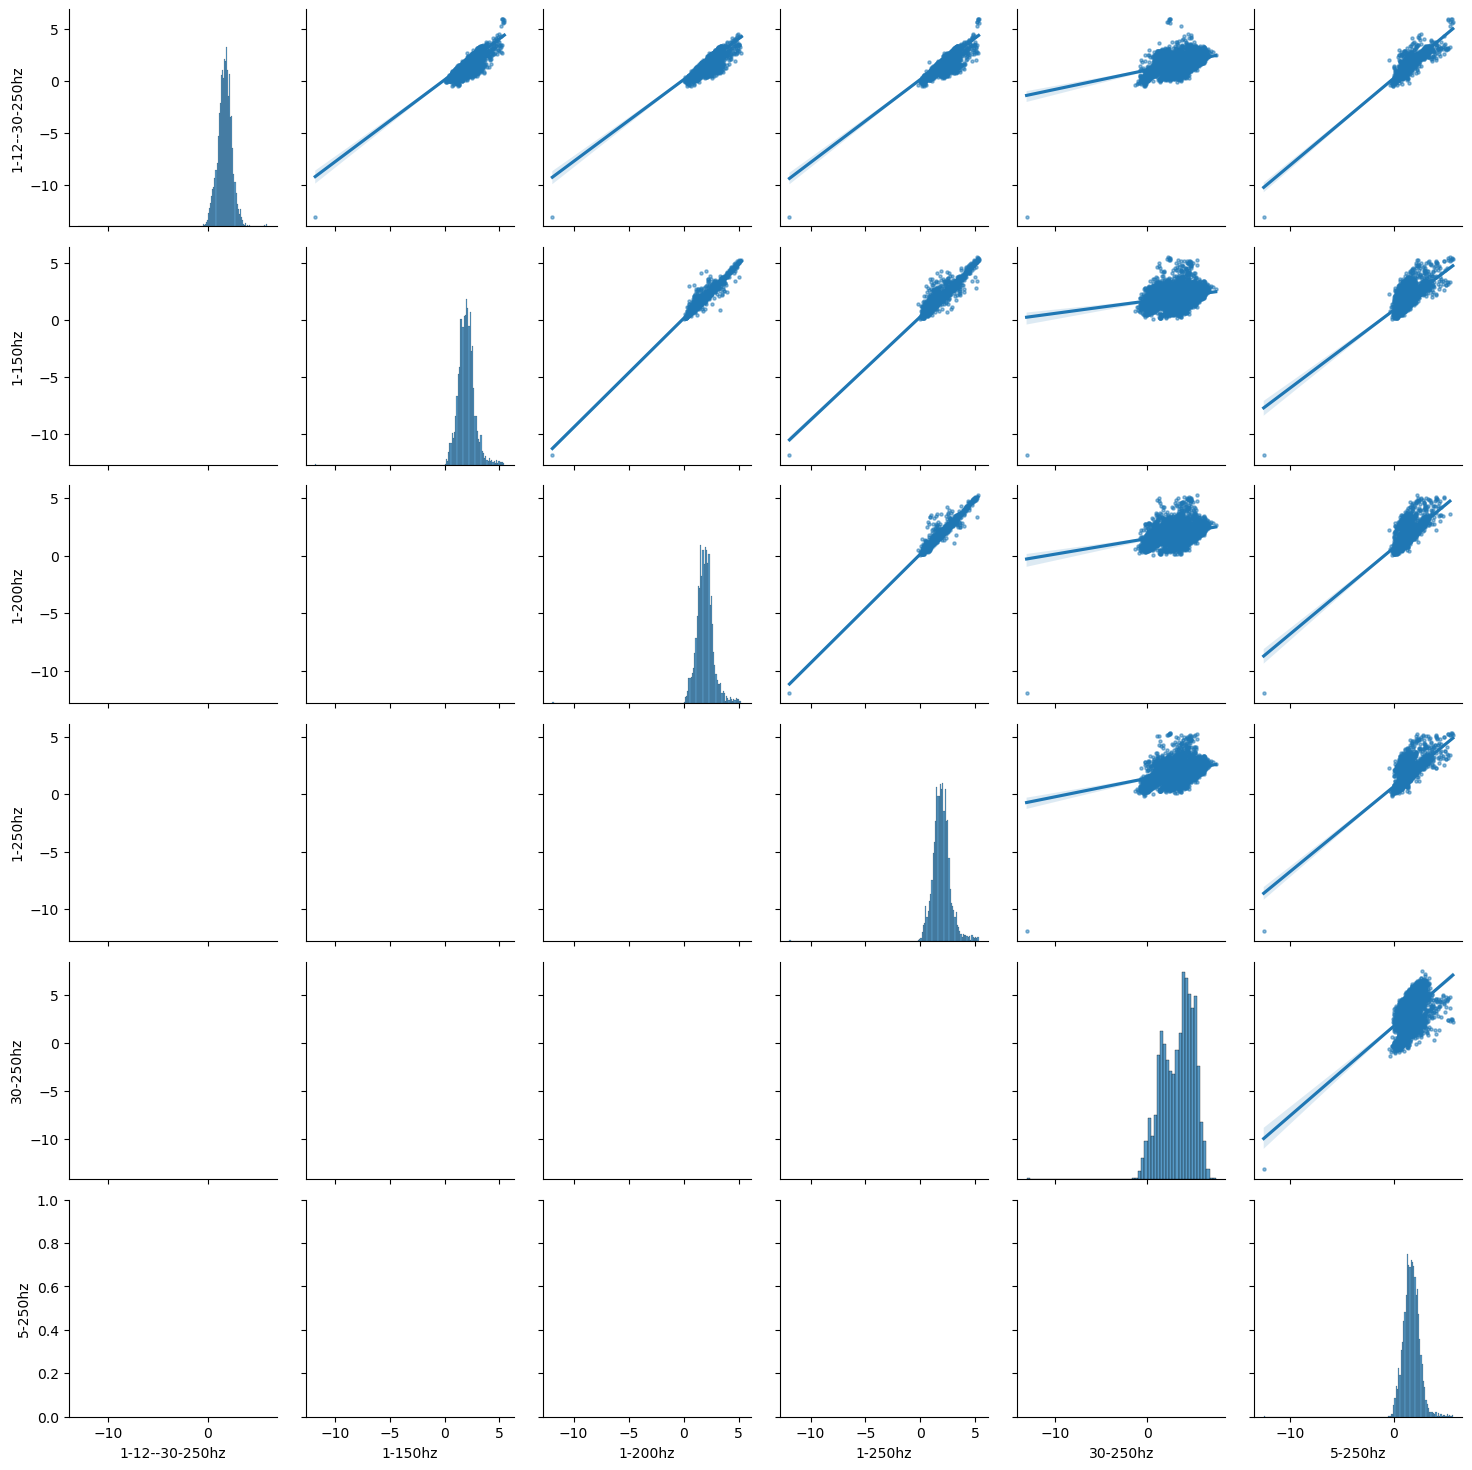

In [69]:
g = sns.PairGrid(df_results_median_pivot['offset'])
g.map_diag(sns.histplot)
g.map_upper(sns.regplot, ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

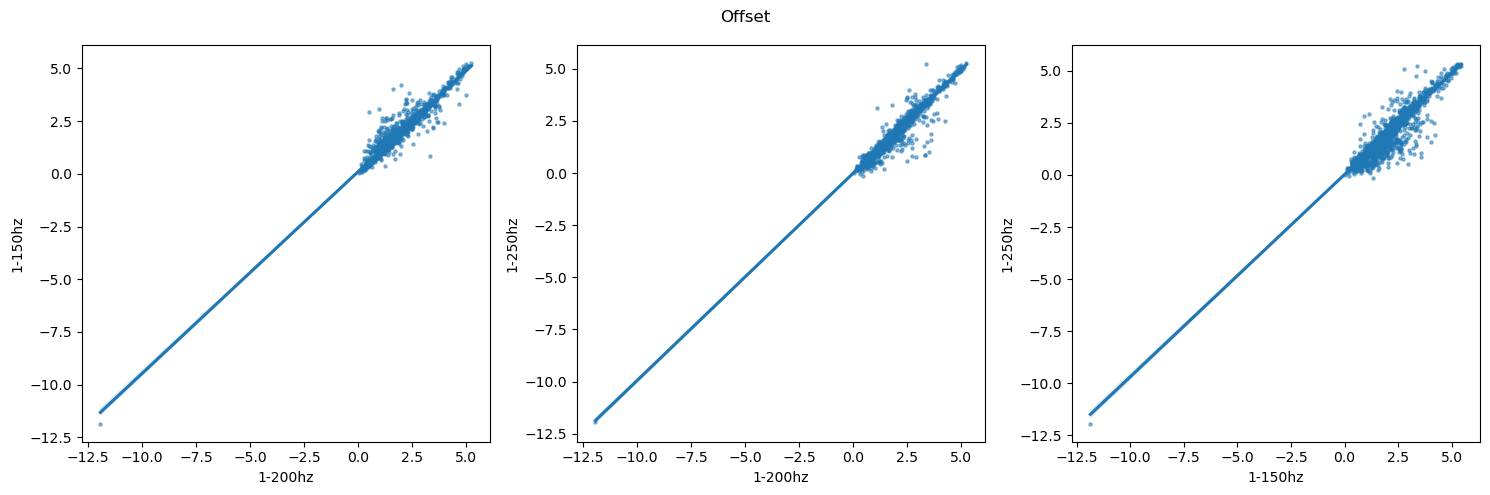

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.regplot(x=df_results_median_pivot['offset']['1-200hz'], 
            y=df_results_median_pivot['offset']['1-150hz'],
            ax=axes[0],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['offset']['1-200hz'], 
            y=df_results_median_pivot['offset']['1-250hz'],
              ax=axes[1],
              ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['offset']['1-150hz'], 
            y=df_results_median_pivot['offset']['1-250hz'], 
            ax=axes[2],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

plt.suptitle('Offset')
plt.tight_layout()
plt.show()

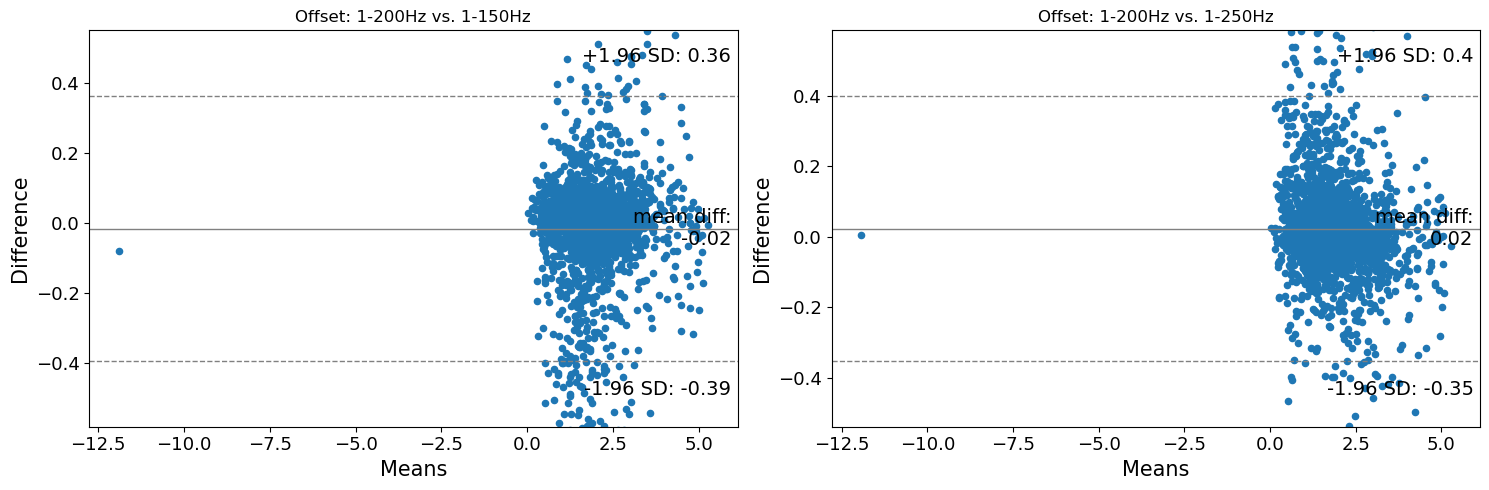

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.mean_diff_plot(df_results_median_pivot['offset']['1-200hz'], df_results_median_pivot['offset']['1-150hz'], ax=axes[0])
axes[0].set_title('Offset: 1-200Hz vs. 1-150Hz')

sm.graphics.mean_diff_plot(df_results_median_pivot['offset']['1-200hz'], df_results_median_pivot['offset']['1-250hz'], ax=axes[1])
axes[1].set_title('Offset: 1-200Hz vs. 1-250Hz')

plt.tight_layout()
plt.show()

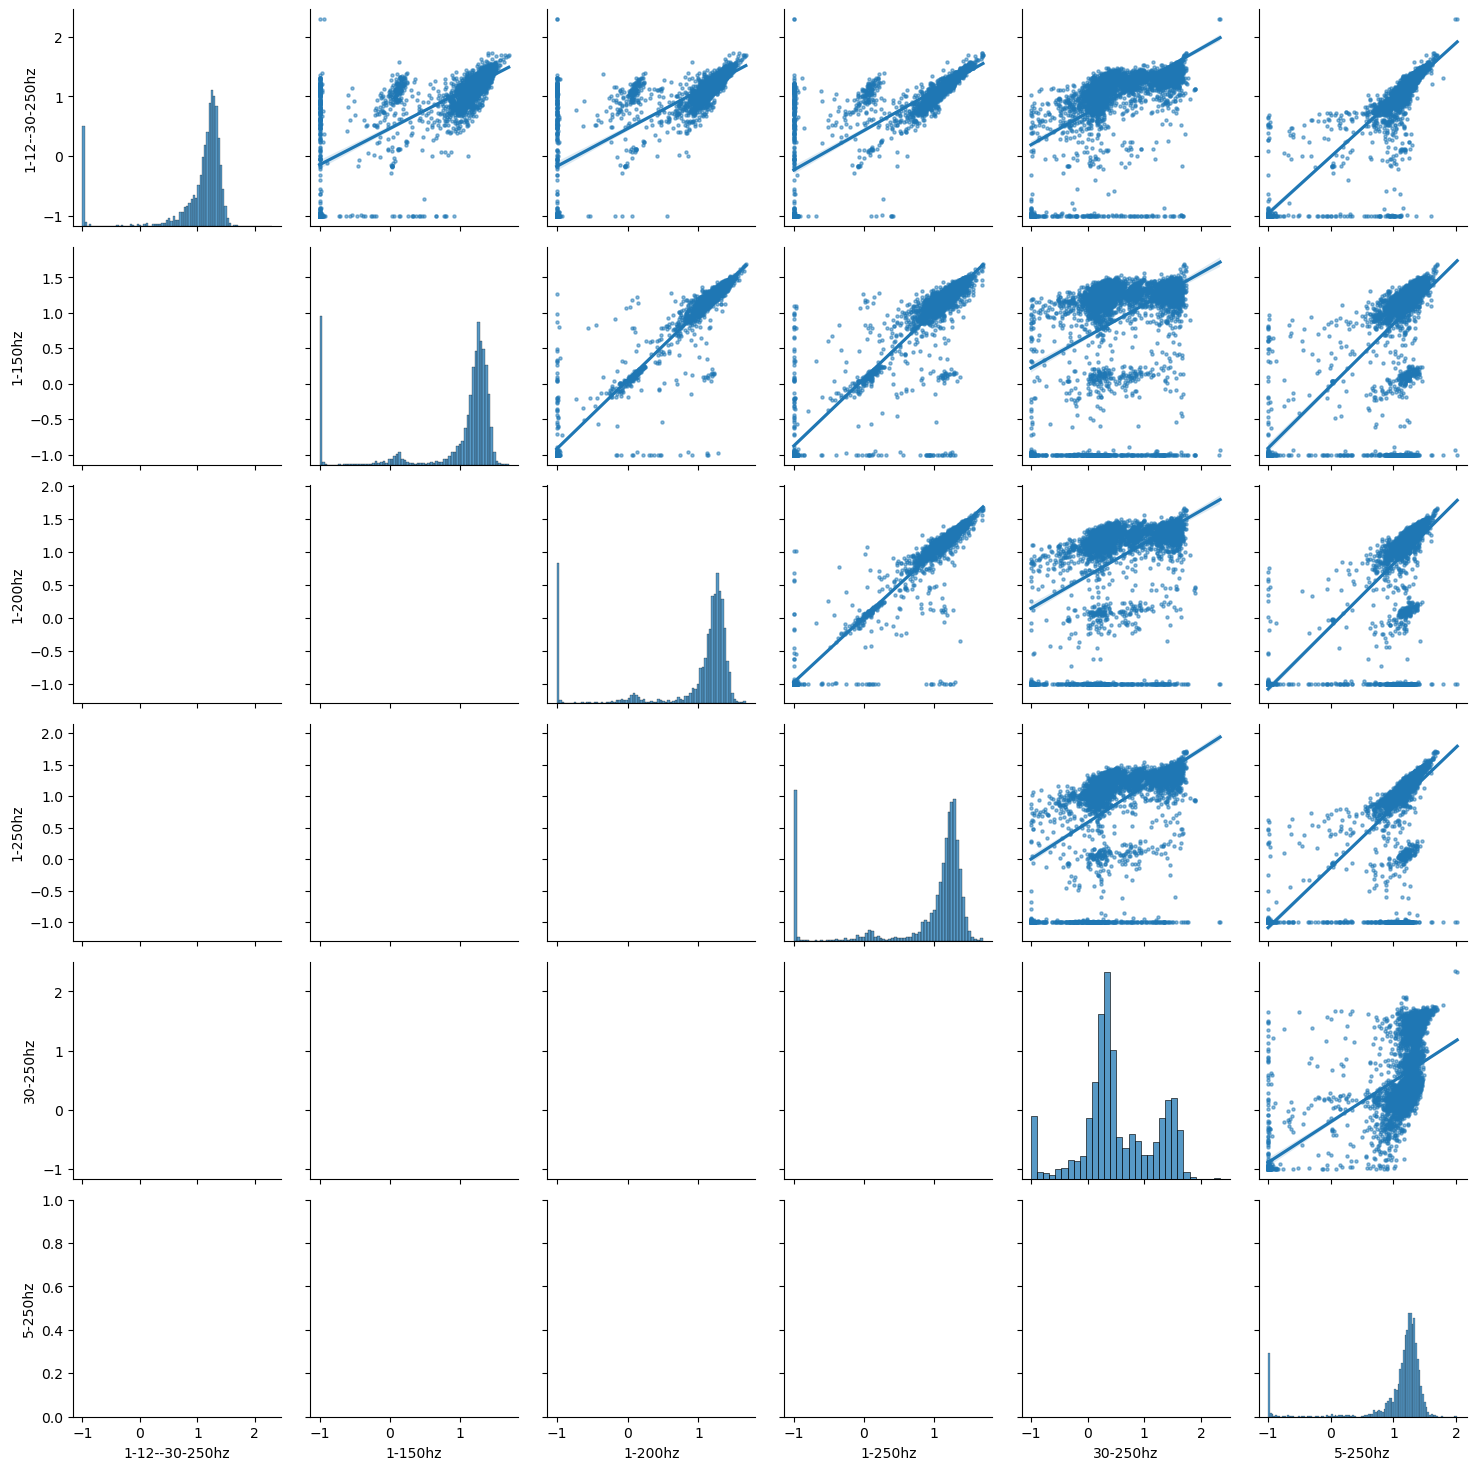

In [72]:
g = sns.PairGrid(df_results_median_pivot['log_knee'])
g.map_diag(sns.histplot)
g.map_upper(sns.regplot, ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

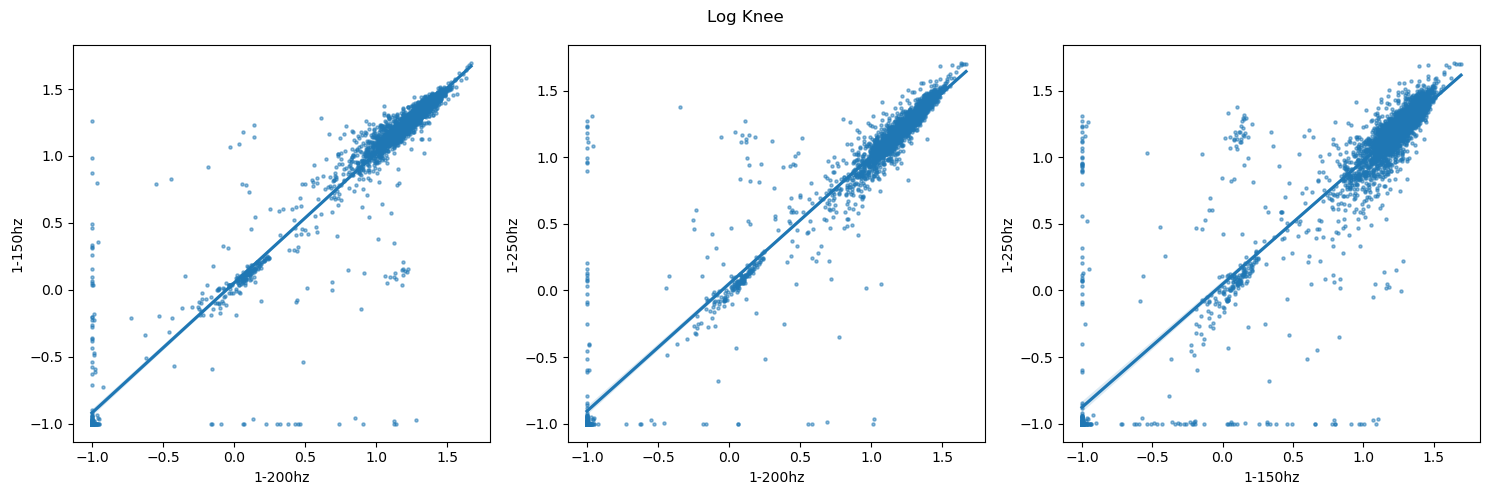

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.regplot(x=df_results_median_pivot['log_knee']['1-200hz'], 
            y=df_results_median_pivot['log_knee']['1-150hz'],
            ax=axes[0],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['log_knee']['1-200hz'], 
            y=df_results_median_pivot['log_knee']['1-250hz'],
              ax=axes[1],
              ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['log_knee']['1-150hz'], 
            y=df_results_median_pivot['log_knee']['1-250hz'], 
            ax=axes[2],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

plt.suptitle('Log Knee')
plt.tight_layout()
plt.show()

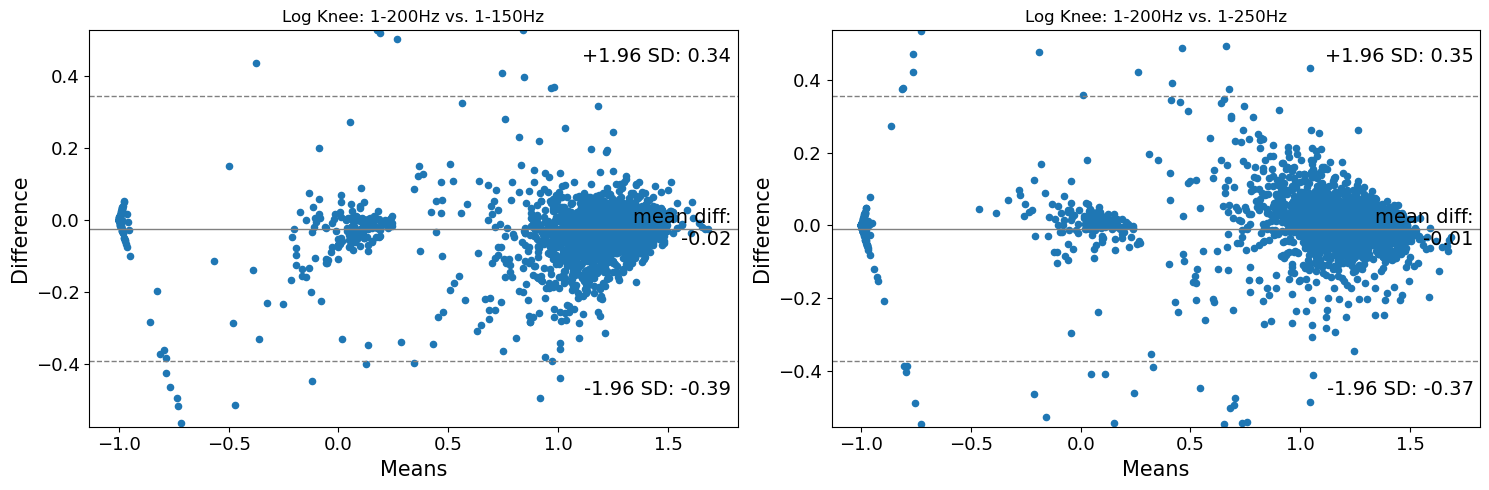

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.mean_diff_plot(df_results_median_pivot['log_knee']['1-200hz'], df_results_median_pivot['log_knee']['1-150hz'], ax=axes[0])
axes[0].set_title('Log Knee: 1-200Hz vs. 1-150Hz')

sm.graphics.mean_diff_plot(df_results_median_pivot['log_knee']['1-200hz'], df_results_median_pivot['log_knee']['1-250hz'], ax=axes[1])
axes[1].set_title('Log Knee: 1-200Hz vs. 1-250Hz')

plt.tight_layout()
plt.show()

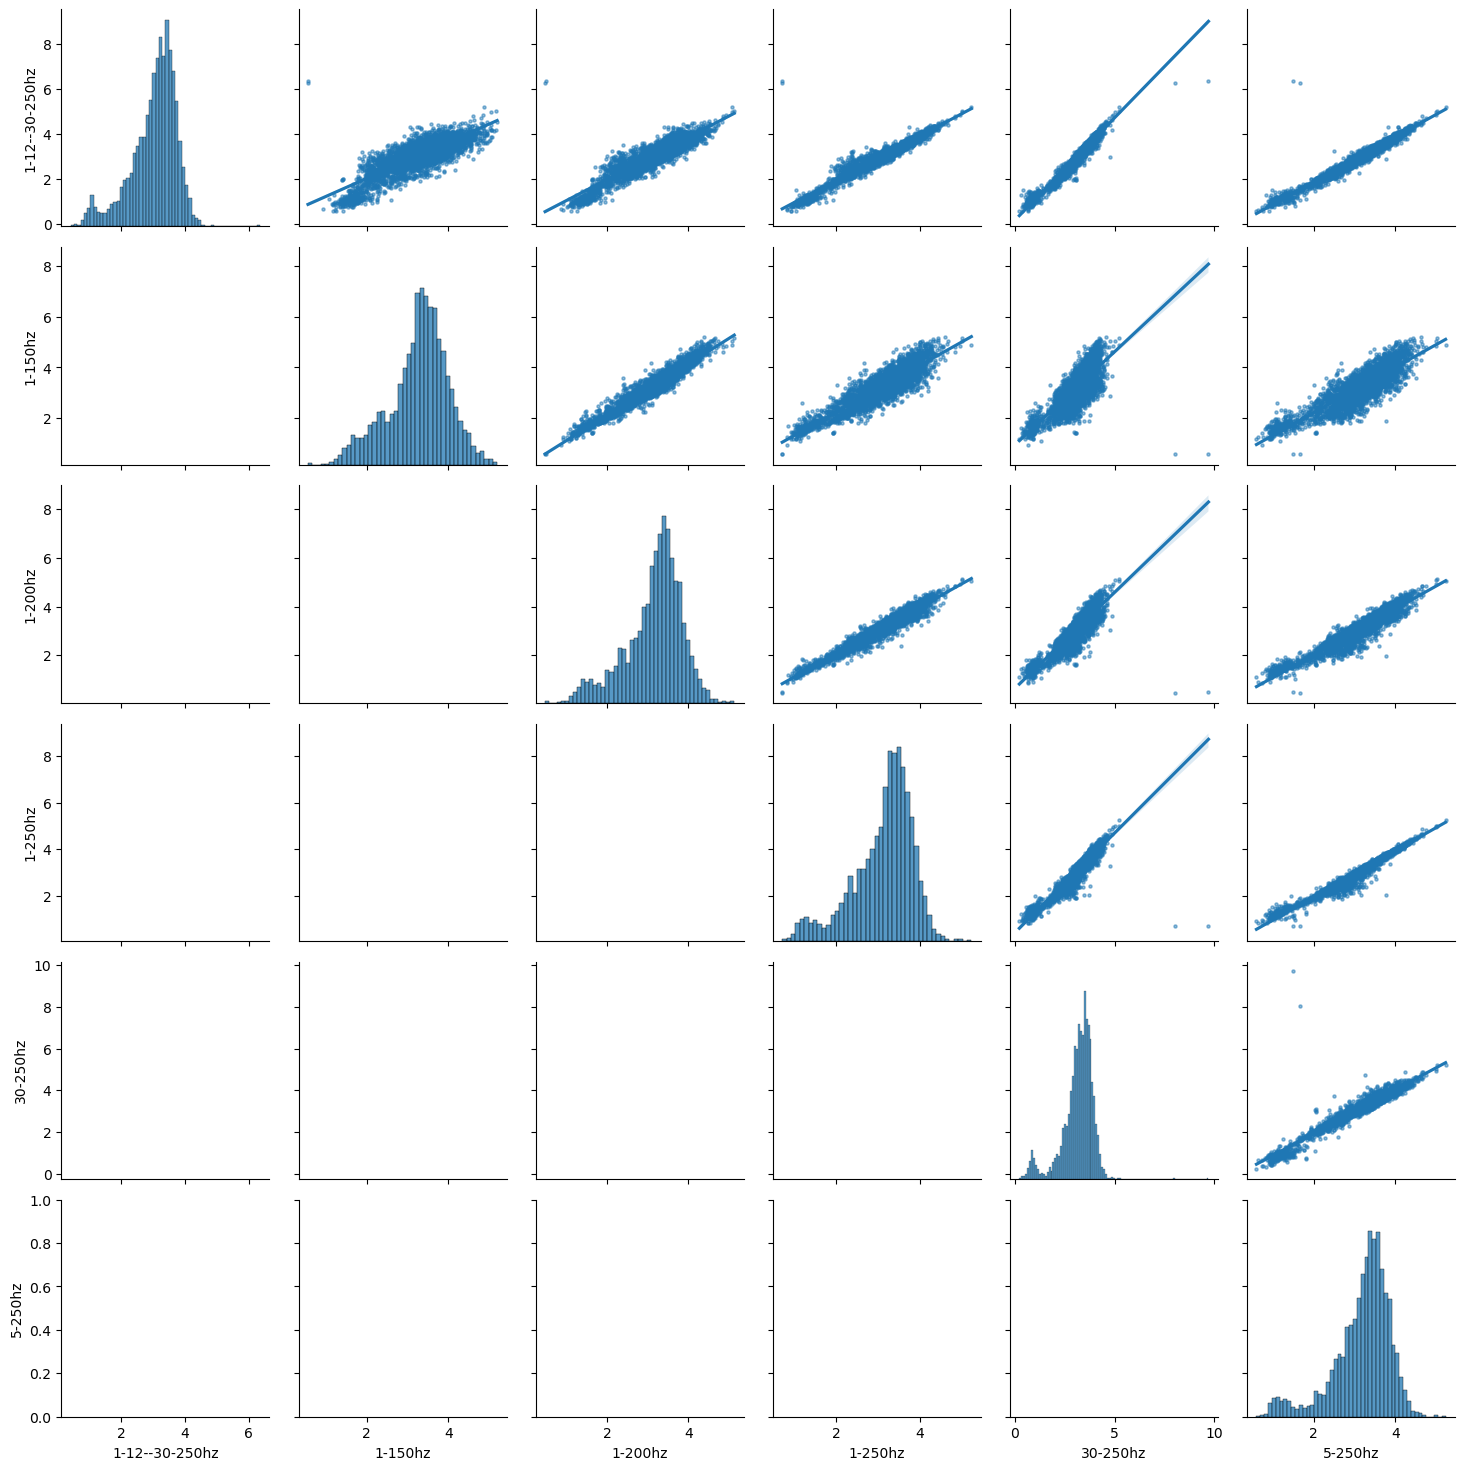

In [75]:
g = sns.PairGrid(df_results_median_pivot['exponent'])
g.map_diag(sns.histplot)
g.map_upper(sns.regplot, ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

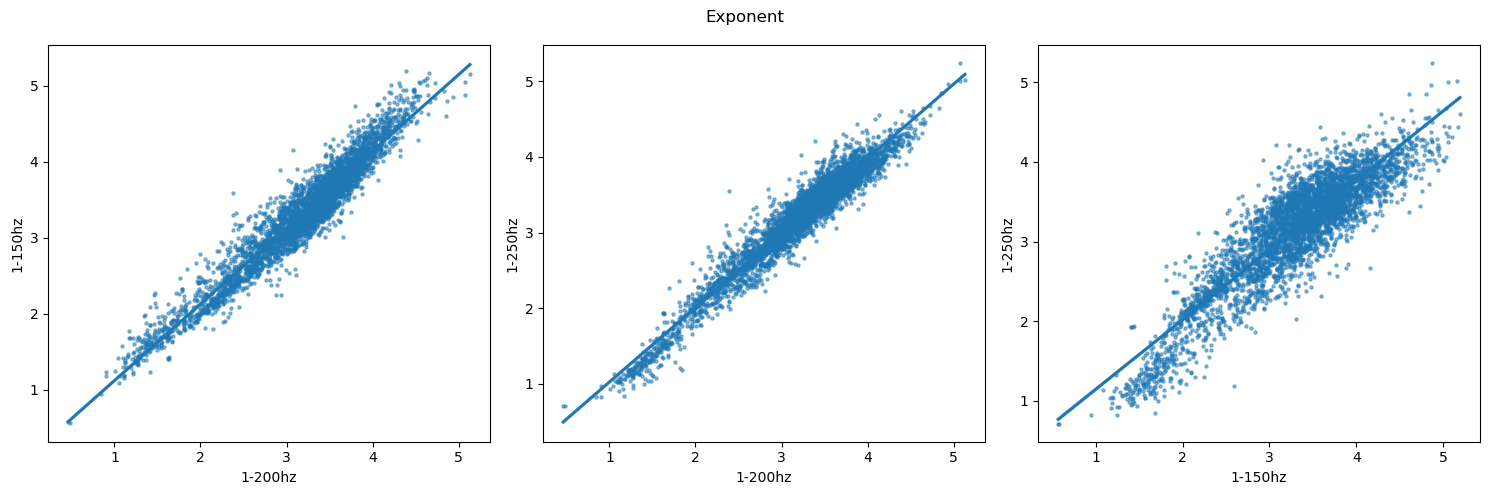

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.regplot(x=df_results_median_pivot['exponent']['1-200hz'], 
            y=df_results_median_pivot['exponent']['1-150hz'],
            ax=axes[0],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['exponent']['1-200hz'], 
            y=df_results_median_pivot['exponent']['1-250hz'],
              ax=axes[1],
              ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['exponent']['1-150hz'], 
            y=df_results_median_pivot['exponent']['1-250hz'], 
            ax=axes[2],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

plt.suptitle('Exponent')
plt.tight_layout()
plt.show()

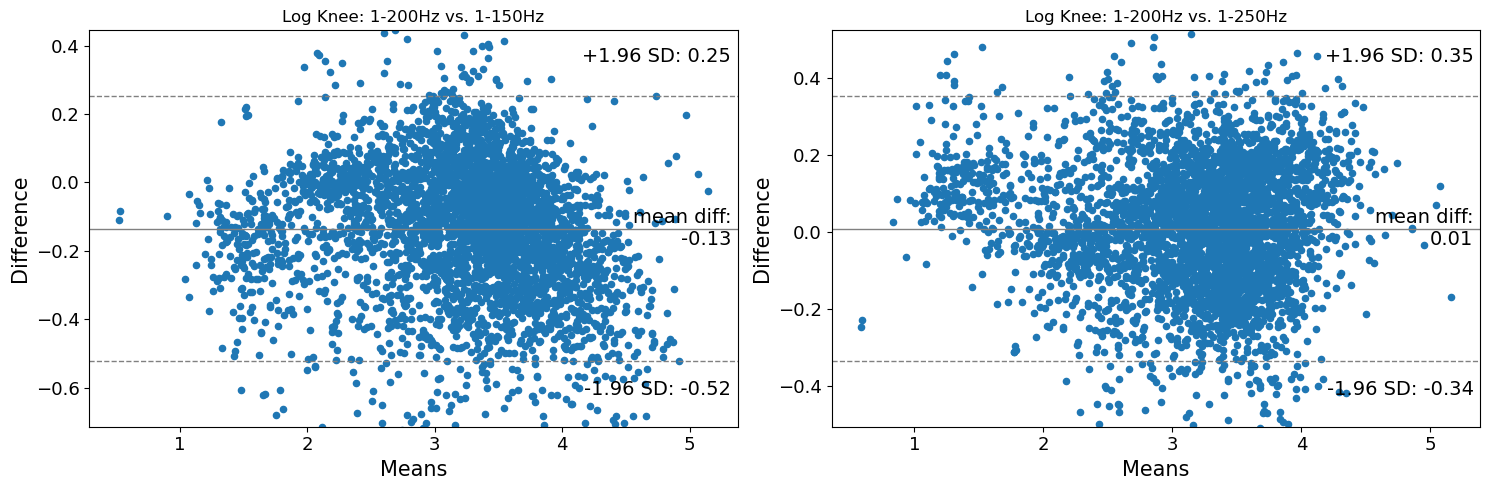

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.mean_diff_plot(df_results_median_pivot['exponent']['1-200hz'], df_results_median_pivot['exponent']['1-150hz'], ax=axes[0])
axes[0].set_title('Log Knee: 1-200Hz vs. 1-150Hz')

sm.graphics.mean_diff_plot(df_results_median_pivot['exponent']['1-200hz'], df_results_median_pivot['exponent']['1-250hz'], ax=axes[1])
axes[1].set_title('Log Knee: 1-200Hz vs. 1-250Hz')

plt.tight_layout()
plt.show()